In [1]:
import os
from sklearn.svm import SVC
import numpy as np
import random
from PIL import Image, ImageOps
from sklearn.metrics import accuracy_score
import glob
import matplotlib.pyplot as plt


# 分類クラス
classes = ['ari', 'nashi']
nb_classes = len(classes)
batch_size_for_data_generator = 30

base_dir = "/Users/watanabekeisuke/Documents/修士論文/乱気流/乱気流画像２/乱気流画像２２"
train_dir = os.path.join(base_dir, 'train')
#validation_dir = os.path.join(base_dir, 'test')
test_dir = os.path.join(base_dir, 'test')

train_ari_dir = os.path.join(train_dir, 'ari/ari')
train_nashi_dir = os.path.join(train_dir, 'nashi/nashi')

test_ari_dir = os.path.join(test_dir, 'ari/ari')
test_nashi_dir = os.path.join(test_dir, 'nashi/nashi')

#img_rows, img_cols = 432, 288

num_of_data_total = 3000
N_col = 432*288*1 # 行列の列数
X_train = np.zeros((num_of_data_total, N_col)) # 学習データ格納のためゼロ行列生成
y_train = np.zeros((num_of_data_total)) # 学習データに対するラベルを格納するためのゼロ行列生成

# 乱気流あり画像を行列に読み込む
path_list = glob.glob(train_ari_dir + "/*") 
i_count = 0

for item in path_list:
    im = Image.open(item).convert('L')
    img_resize =im.resize((432,288))
    im_array = np.ravel(np.asarray(img_resize))
    im_regularized = im_array/255.
    X_train[i_count,:] =  im_regularized
    y_train[i_count] = 0
    i_count += 1
    
#乱気流なし画像を行列に読み込む
path_list = glob.glob(train_nashi_dir + "/*") 

for item in path_list:
    im = Image.open(item).convert('L')   
    img_resize = im.resize((432,288))
    im_array = np.ravel(np.asarray(img_resize))
    im_regularized = im_array/255.
    X_train[i_count,:] = im_regularized
    y_train[i_count] = 1
    i_count += 1
    

num_of_data_total = 600
X_test = np.zeros((num_of_data_total, N_col))
y_test = np.zeros(num_of_data_total)


    
# 乱気流あり画像を行列に読み込む（テストデータ）
path_list = glob.glob(test_ari_dir+ "/*") 
i_count = 0
for item in path_list:
    im = Image.open(item).convert('L')
    img_resize =im.resize((432,288))
    im_array = np.ravel(np.array(img_resize))
    im_mean_subtract = im_array/255.
    X_test[i_count,:] =  im_mean_subtract
    y_test[i_count] = 0
    i_count += 1

# 乱気流なし画像を行列に読み込む（テストデータ）
path_list = glob.glob(test_nashi_dir+ "/*") 

for item in path_list:
    im = Image.open(item).convert('L')   
    img_resize = im.resize((432,288))
    im_array = np.ravel(np.array(img_resize))
    im_regularized = im_array/255.
    X_test[i_count,:] = im_regularized
    y_test[i_count] = 1
    i_count += 1 

In [2]:
#PCAによる次元削減
from sklearn.decomposition import PCA
N_dim =  100

pca = PCA(n_components=N_dim, random_state=0)

X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print('累積寄与率: {0}'.format(sum(pca.explained_variance_ratio_)))

累積寄与率: 0.9983125567427512


In [3]:
#非線形SVM
model_nonlinearSVC = SVC(C=0.3, kernel='rbf', random_state=0)
model_nonlinearSVC.fit(X_train_pca, y_train)

# 精度
print("Train :", model_nonlinearSVC.score(X_train_pca,  y_train))
print("Test :", model_nonlinearSVC.score(X_test_pca, y_test))

Train : 0.997
Test : 0.8266666666666667


In [4]:
#線形SVM
from sklearn.svm import LinearSVC
model_linearSVC = LinearSVC(C=0.3, random_state=0)
model_linearSVC.fit(X_train_pca, y_train)

print("Train :", model_linearSVC.score(X_train_pca,  y_train))
print("Test :", model_linearSVC.score(X_test_pca, y_test))

Train : 0.9996666666666667
Test : 0.8266666666666667


/Users/watanabekeisuke/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


In [5]:
#XGBoost
import xgboost as xgb
model_xgb = xgb.XGBClassifier(n_estimators=80, max_depth=4, gamma=3)
model_xgb.fit(X_train_pca, y_train)

# 精度
print("Train :", model_xgb.score(X_train_pca,  y_train))
print("Test :", model_xgb.score(X_test_pca, y_test))

Train : 0.999
Test : 0.8266666666666667


In [6]:
#KNN
from sklearn.neighbors import KNeighborsClassifier

n_neighbors = int(np.sqrt(6000))

model_kNN = KNeighborsClassifier(n_neighbors = n_neighbors) 
model_kNN.fit(X_train_pca, y_train)
    
# 精度
print("Train :", model_kNN.score(X_train_pca, y_train))
print("Test :", model_kNN.score(X_test_pca, y_test))

Train : 0.9793333333333333
Test : 0.8233333333333334


In [7]:
#ランダムフォレスト
from sklearn.ensemble import RandomForestClassifier as rfc

model_randomforest = rfc(max_depth=3, random_state=0)
model_randomforest.fit(X_train_pca, y_train)

# 精度
print("Train :", model_randomforest.score(X_train_pca, y_train))
print("Test :", model_randomforest.score(X_test_pca, y_test))

Train : 0.966
Test : 0.8033333333333333


In [8]:
from sklearn.model_selection import learning_curve
train_sizes = np.array([0.1, 0.33, 0.55, 0.78, 1. ]) #用いる学習データの割合を全体の0.1〜1まで変化させる

train_sizes, train_scores_linearSVC, test_scores_linearSVC = learning_curve(
    model_linearSVC, X_train_pca, y_train, cv=5, train_sizes=train_sizes, random_state=0, shuffle=True
    )#様々学習データ数に対して、モデルを学習・評価する。

#各学習データ数の場合について学習用データと検証用データに対する精度を求める。
train_scores_mean_linearSVC = np.mean(train_scores_linearSVC, axis=1)
train_scores_std_linearSVC = np.std(train_scores_linearSVC, axis=1)
validation_scores_mean_linearSVC = np.mean(test_scores_linearSVC, axis=1)
validation_scores_std_linearSVC = np.std(test_scores_linearSVC, axis=1)

/Users/watanabekeisuke/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/Users/watanabekeisuke/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/Users/watanabekeisuke/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/Users/watanabekeisuke/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/Users/watanabekeisuke/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/Users/watanabekeisuke/an

In [9]:
train_sizes, train_scores_kNN, test_scores_kNN = learning_curve(
    model_kNN, X_train_pca, y_train, cv=5, train_sizes=train_sizes, random_state=0, shuffle=True
    )#様々学習データ数に対して、モデルを学習・評価する。

#各学習データ数の場合について学習用データと検証用データに対する精度を求める。
train_scores_mean_kNN = np.mean(train_scores_kNN, axis=1)
train_scores_std_kNN = np.std(train_scores_kNN, axis=1)
validation_scores_mean_kNN = np.mean(test_scores_kNN, axis=1)
validation_scores_std_kNN = np.std(test_scores_kNN, axis=1)

In [10]:
train_sizes, train_scores_nonlinearSVC, test_scores_nonlinearSVC = learning_curve(
    model_nonlinearSVC, X_train_pca, y_train, cv=5, train_sizes=train_sizes, random_state=0, shuffle=True
    )#様々学習データ数に対して、モデルを学習・評価する。

#各学習データ数の場合について学習用データと検証用データに対する精度を求める。
train_scores_mean_nonlinearSVC = np.mean(train_scores_nonlinearSVC, axis=1)
train_scores_std_nonlinearSVC = np.std(train_scores_nonlinearSVC, axis=1)
validation_scores_mean_nonlinearSVC = np.mean(test_scores_nonlinearSVC, axis=1)
validation_scores_std_nonlinearSVC = np.std(test_scores_nonlinearSVC, axis=1)

In [11]:
train_sizes, train_scores_xgb, test_scores_xgb = learning_curve(
    model_xgb, X_train_pca, y_train, cv=5, train_sizes=train_sizes, random_state=0, shuffle=True
    )#様々学習データ数に対して、モデルを学習・評価する。

#各学習データ数の場合について学習用データと検証用データに対する精度を求める。
train_scores_mean_xgb = np.mean(train_scores_xgb, axis=1)
train_scores_std_xgb = np.std(train_scores_xgb, axis=1)
validation_scores_mean_xgb = np.mean(test_scores_xgb, axis=1)
validation_scores_std_xgb = np.std(test_scores_xgb, axis=1)

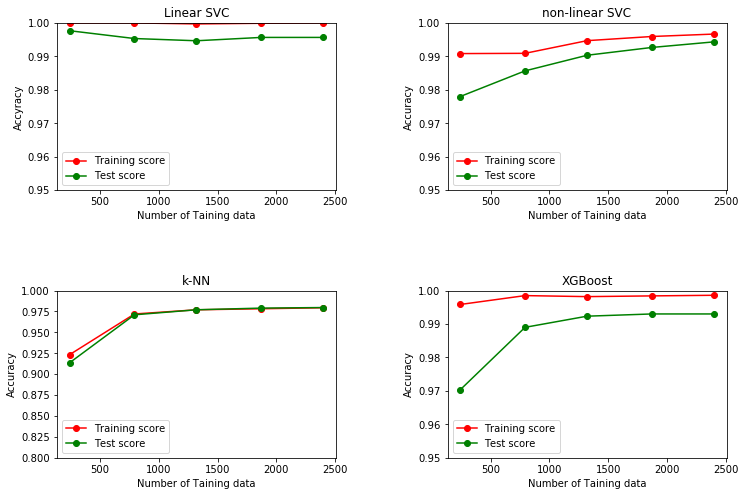

In [12]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
plt.subplots_adjust(wspace=0.4, hspace=0.6)

# Linear SVCの学習曲線
ax[0,0].plot(train_sizes, train_scores_mean_linearSVC, 'o-', color="r", label="Training score")
ax[0,0].plot(train_sizes, validation_scores_mean_linearSVC, 'o-', color="g", label="Test score")

ax[0, 0].set_title('Linear SVC')
ax[0, 0].set_xlabel('Number of Taining data')
ax[0, 0].set_ylabel('Accyracy')
ax[0,0].set_ylim(0.95, 1.0)
#ax[0,0].set_xlim(1000, 4000)
ax[0,0].legend(loc="best")

# kNNの学習曲線
ax[1,0].plot(train_sizes, train_scores_mean_kNN, 'o-', color="r", label="Training score")
ax[1,0].plot(train_sizes, validation_scores_mean_kNN, 'o-', color="g", label="Test score")

ax[1, 0].set_title('k-NN')
ax[1, 0].set_xlabel('Number of Taining data')
ax[1, 0].set_ylabel('Accuracy')
ax[1,0].set_ylim(0.8, 1.0)
ax[1,0].legend(loc="best")

# 非線形SVCの学習曲線
ax[0,1].plot(train_sizes, train_scores_mean_nonlinearSVC, 'o-', color="r", label="Training score")
ax[0,1].plot(train_sizes, validation_scores_mean_nonlinearSVC, 'o-', color="g", label="Test score")
ax[0, 1].set_title('non-linear SVC')
ax[0, 1].set_xlabel('Number of Taining data')
ax[0, 1].set_ylabel('Accuracy')
ax[0,1].set_ylim(0.95, 1.0)
ax[0,1].legend(loc="best")

# XGBoostの学習曲線
ax[1,1].plot(train_sizes, train_scores_mean_xgb, 'o-', color="r", label="Training score")
ax[1,1].plot(train_sizes, validation_scores_mean_xgb, 'o-', color="g", label="Test score")

ax[1, 1].set_title('XGBoost')
ax[1, 1].set_xlabel('Number of Taining data')
ax[1, 1].set_ylabel('Accuracy')
ax[1,1].set_ylim(0.95, 1.0)
ax[1,1].legend(loc="best")